In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import xarray

In [2]:
from wrf import ll_to_xy

In [3]:
from matplotlib.ticker import FormatStrFormatter

In [4]:
from IPython.display import Image

In [5]:
from netCDF4 import Dataset

In [6]:
fs = 16

In [7]:
plt.rc("font",size=fs)

In [20]:
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter

In [ ]:
# import sys
# os.system('module load ffmpeg')

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['animation.ffmpeg_path'] = '/glade/u/apps/ch/opt/ffmpeg/4.1.3/gnu/8.3.0/bin/ffmpeg'

In [8]:
main_path = "/glade/scratch/doubrawa/post_processing/"

In [9]:
k = 8

## equivalent coords

In [15]:
ref_wrfnc = Dataset("/glade/scratch/doubrawa/final_data/les/032815/032815_14UTC/wrfout_d04_2015-03-28_14:00:00_0000")

we_ref, sn_ref = ll_to_xy(ref_wrfnc, data["YSU"]["xlat"], data["YSU"]["xlong"])

we_ref = we_ref.values.reshape((90,90))
sn_ref = sn_ref.values.reshape((90,90))

# open the clipped and filtered datasets

In [32]:
sims    = ['VLES','MYNN','YSU','SH','LES']
varname = 'theta'

In [135]:
day    = 30
itime  = 0
arrays = {}
x_arrays = {}
y_arrays = {}

for hour in np.arange(14,24,1):
    print("hour {0}".format(hour))

    for minute in np.arange(0,60,10):
        print("minute: {0}".format(minute))

        data = {}

        for sim in ['VLES','MYNN','YSU','SH']:
            fname = glob.glob(os.path.join(main_path,"WRF_{3}_3D_2015-03-{0}_{1:02d}:{2:02d}*".format(day,hour,minute,sim.lower())))[0]
            #print(os.path.split(fname)[-1])
            data[sim] = xarray.open_dataset(fname) 

        wrfouts = sorted(glob.glob(os.path.join(main_path,'WRF_LES_25m_3D_2015-03-{1}_{2}:{3:02d}_plus*'.format(height,day,hour,minute))))
        wrfout  = wrfouts[0]
        #print (os.path.split(wrfout)[-1])                

        data["LES"] = xarray.open_dataset(wrfout)    

        if varname in ['ws','wd','u','v','w']:
            for sim in data.keys():
                data[sim]["ws"] = np.sqrt(data[sim].u**2+data[sim].v**2)
                data[sim]["ws_filt"] = np.sqrt(data[sim].u_filt**2+data[sim].v_filt**2) 

        contour = data["LES"][varname].isel(bottom_top=k)
        xx      = contour.west_east
        yy      = contour.south_north
        xymean  = np.mean(contour.values)
        contour = contour.values-xymean    
        
        
        if itime==0:
            arrays["LES"]   = contour[np.newaxis,:,:].copy()
            x_arrays["LES"] = xx.copy()
            y_arrays["LES"] = yy.copy()
            
            contour = data["LES"][varname+"_filt"].isel(bottom_top=k).values - xymean
            arrays["LES_filt"]   = contour[np.newaxis,:,:].copy()
            x_arrays["LES_filt"] = xx.copy()
            y_arrays["LES_filt"] = yy.copy()
            
            for sim in ['VLES','MYNN','YSU','SH']:  
                contour     = data[sim][varname+"_filt"].isel(bottom_top=k)
                contour     = contour.values-xymean
                xx          = tmp.west_east
                yy          = tmp.south_north                
                arrays[sim] = contour[np.newaxis,:,:].copy()
                x_arrays[sim] = xx.copy()
                y_arrays[sim] = yy.copy()
                
            zref = [float(data["LES"].z.isel(bottom_top=k).mean().values)]
            datetimes = [data["LES"].valid]
        else:
            arrays["LES"] = np.append(arrays["LES"], contour[np.newaxis,:,:], 0)    
            
            contour = data["LES"][varname+"_filt"].isel(bottom_top=k).values - xymean
            arrays["LES_filt"]   = np.append(arrays["LES_filt"], contour[np.newaxis,:,:], 0)           
            
            zref.append(float(data["LES"].z.isel(bottom_top=k).mean().values))
            datetimes.append(data["LES"].valid)
            for sim in ['VLES','MYNN','YSU','SH']:                
                contour     = data[sim][varname+"_filt"].isel(bottom_top=k)
                contour     = contour.values-xymean                
                arrays[sim] = np.append(arrays[sim], contour[np.newaxis,:,:], 0)
                
        #print(itime,arrays["LES"].shape)
        #print(itime,arrays["YSU"].shape)        
            
        itime += 1

zref=np.asarray(zref)
datetimes=np.asarray(datetimes)

hour 14
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 15
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 16
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 17
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 18
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 19
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 20
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 21
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 22
minute: 0
minute: 10
minute: 20
minute: 30
minute: 40
minute: 50
hour 23
minute: 0


IndexError: list index out of range

# plot

In [123]:
titles = {"LES_filt":"RLES (filtered)",
          "MYNN":"MYNN (clipped and filtered)", 
          "YSU":"YSU (clipped and filtered)",
          "SH":"SH (clipped and filtered)",
          "VLES":"VLES (clipped and filtered)"}

sup_titles = {'theta':'Potential Temperature Perturbation'+'\n'+r'$\theta - \langle \theta_{{RLES}} \rangle_{{xy}} $ [K] at $z\sim{0:.0f}$ m'.format(np.mean(zref))}

## first figure

In [116]:
i = 0

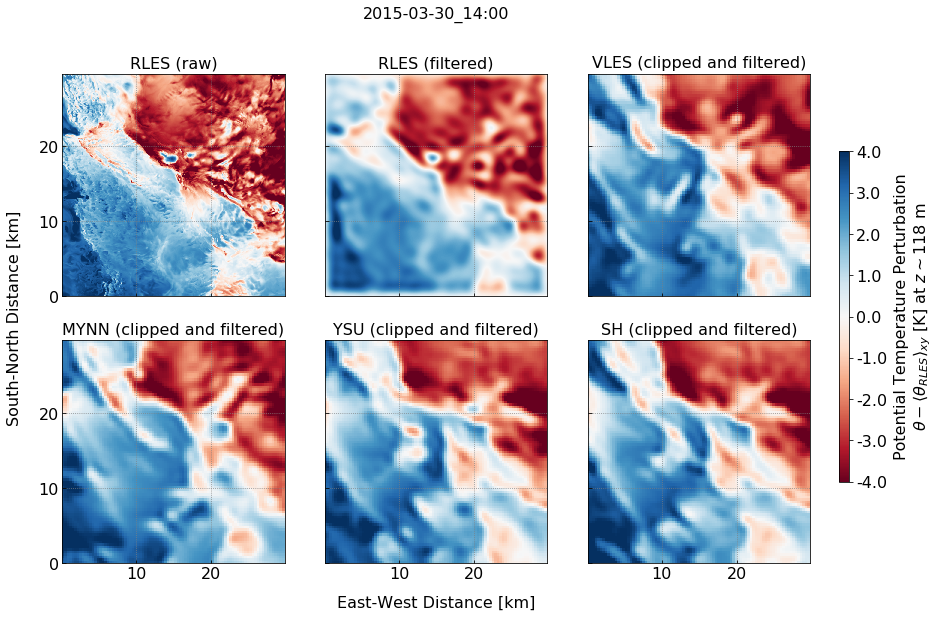

In [131]:
title = sup_titles[varname]

levels = np.arange(-4,4.001,0.1)

nrows = 2
ncols = 3

fig   = plt.figure(figsize=(5*ncols,4.5*nrows))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axbig.set_xlabel("East-West Distance [km]",labelpad=10)
axbig.set_ylabel("South-North Distance [km]",labelpad=-10)
axbig.set_title(datetimes[i], fontsize=fs, y=1.1)

desired_ticks = [0,10,20,30]
xticks        = [(ii*1000)/25.0 for ii in desired_ticks]
labels        = ["{0:.0f}".format(dx) for dx in desired_ticks]

ax  = {}
p = {}
iax = 1


#
# raw les
#
ax[iax] = fig.add_subplot(nrows,ncols,iax,aspect='equal')

contour    = arrays["LES"][i,...]
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
p[iax] = ax[iax].pcolormesh(x_arrays["LES"],y_arrays["LES"],contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
ax[iax].xaxis.set_tick_params(direction='in')
ax[iax].yaxis.set_tick_params(direction='in') 
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(labels,fontsize=fs)
ax[iax].set_yticks(xticks)
ax[iax].set_yticklabels(labels,fontsize=fs)  
ax[iax].grid(color='gray',linestyle=':')
ax[iax].set_title("RLES (raw)",fontsize=fs)
ax[iax].set_xlim([xmin,xmax])
ax[iax].set_ylim([ymin,ymax])    

iax += 1

for sim in ["LES_filt","VLES","MYNN","YSU","SH"]:

    ax[iax] = fig.add_subplot(nrows,ncols,iax,sharex=ax[1],sharey=ax[1],aspect='equal')
    contour = arrays[sim][i,...]
    xx      = x_arrays[sim]
    yy      = y_arrays[sim]

    if ((sim!="LES")&(sim!="LES_filt")):
        xx = we_ref
        yy = sn_ref
    p[iax] = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
    ax[iax].xaxis.set_tick_params(direction='in')
    ax[iax].yaxis.set_tick_params(direction='in')    
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(labels,fontsize=fs)    
    ax[iax].set_yticks(xticks)
    ax[iax].set_yticklabels(labels,fontsize=fs)   
    ax[iax].grid(color='gray',linestyle=':')
    ax[iax].set_title(titles[sim],fontsize=fs) 
    ax[iax].set_xlim([xmin,xmax])
    ax[iax].set_ylim([ymin,ymax])    

    iax += 1

for iax in [2,3,5,6]:
    plt.setp(ax[iax].get_yticklabels(), visible=False)

for iax in [1,2,3]:    
    plt.setp(ax[iax].get_xticklabels(), visible=False)


fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.86, 0.25, 0.01, 0.51])
clb = fig.colorbar(p[iax], cax=cbar_ax, format=FormatStrFormatter('%3.1f'))
clb.set_label(title, labelpad=10)

In [126]:
def animate(i):
    
    contour    = arrays["LES"][i,...]
    iax        = 1
    ax[iax].collections = []
    p[iax]     = ax[iax].pcolormesh(x_arrays["LES"],y_arrays["LES"],contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    
    
    for sim in ["LES_filt","VLES","MYNN","YSU","SH"]:

        iax += 1

        contour = arrays[sim][i,...]
        xx      = x_arrays[sim]
        yy      = y_arrays[sim]
        
        if ((sim!="LES")&(sim!="LES_filt")):
            xx = we_ref
            yy = sn_ref
        
        ax[iax].collections = []
        p[iax] = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="RdBu")    

    axbig.set_title(datetimes[i], fontsize=fs, y=1.1)

In [132]:
anim = FuncAnimation(fig, animate, interval=600, frames=range(4))

In [133]:
anim

### wind speed

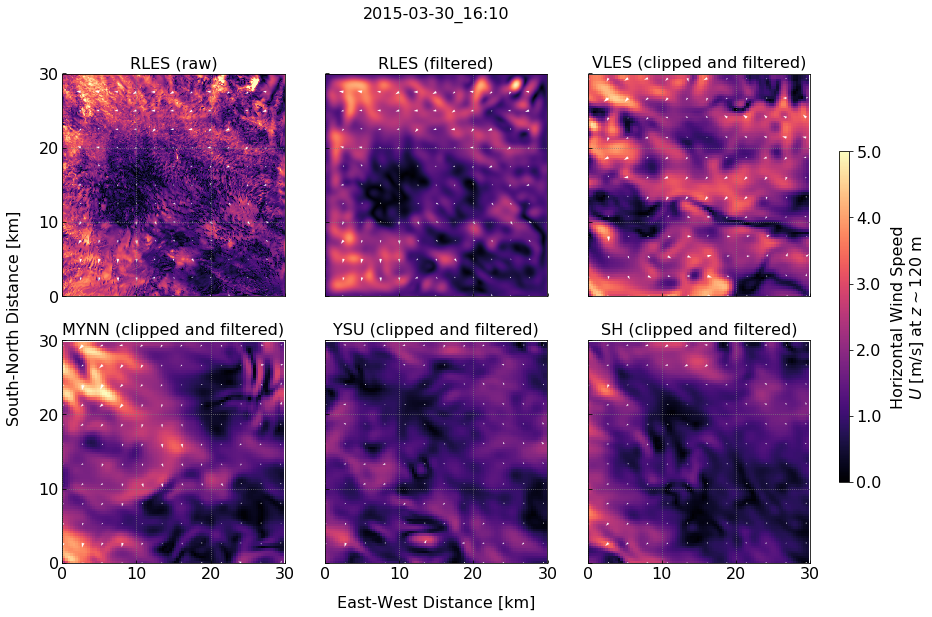

In [124]:
levels = np.arange(0, 5.01, 1)

nrows = 2
ncols = 3

fig   = plt.figure(figsize=(5*ncols,4.5*nrows))

axbig = fig.add_subplot(111)
axbig.spines['top'].set_color('none')
axbig.spines['bottom'].set_color('none')
axbig.spines['left'].set_color('none')
axbig.spines['right'].set_color('none')
axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axbig.set_xlabel("East-West Distance [km]",labelpad=10)
axbig.set_ylabel("South-North Distance [km]",labelpad=-10)
axbig.set_title(data["LES"].valid, fontsize=fs, y=1.1)

desired_ticks = [0,10,20,30]
xticks        = [(ii*1000)/25.0 for ii in desired_ticks]
labels        = ["{0:.0f}".format(dx) for dx in desired_ticks]
    
ax  = {}
iax = 1


#
# raw les
#
ax[iax] = fig.add_subplot(nrows,ncols,iax,aspect='equal')

tmp     = data["LES"]["ws"].isel(bottom_top=k)
xx      = tmp.west_east
yy      = tmp.south_north
uu      = data["LES"]["u"].isel(bottom_top=k)
vv      = data["LES"]["v"].isel(bottom_top=k)
contour = tmp.values
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)

p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="magma")  

skip = 100
q = ax[iax].quiver(xx[::skip],yy[::skip],
                   uu[::skip,::skip],vv[::skip,::skip],color='w',units='xy',scale_units='inches',scale=50)    

ax[iax].xaxis.set_tick_params(direction='in')
ax[iax].yaxis.set_tick_params(direction='in') 
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(labels,fontsize=fs)
ax[iax].set_yticks(xticks)
ax[iax].set_yticklabels(labels,fontsize=fs)  
ax[iax].grid(color='gray',linestyle=':')
ax[iax].set_title("RLES (raw)",fontsize=fs)
ax[iax].set_xlim([xmin,xmax])
ax[iax].set_ylim([ymin,ymax])    

iax += 1

for sim in ["LES","VLES","MYNN","YSU","SH"]:

    ax[iax] = fig.add_subplot(nrows,ncols,iax,sharex=ax[1],sharey=ax[1],aspect='equal')
    tmp     = data[sim]["ws_filt"].isel(bottom_top=k)
    xx      = tmp.west_east
    yy      = tmp.south_north
    uu      = data[sim]["u"].isel(bottom_top=k)
    vv      = data[sim]["v"].isel(bottom_top=k)    
    skip    = 100
    if sim!="LES":
        xx = we_ref[0,:]
        yy = sn_ref[:,0]
        skip = 8
    contour = tmp.values
    p = ax[iax].pcolormesh(xx,yy,contour,vmin=np.min(levels),vmax=np.max(levels),cmap="magma")  
    q = ax[iax].quiver(xx[::skip],yy[::skip],
                       uu[::skip,::skip],vv[::skip,::skip],color='w',units='xy',scale_units='inches',scale=50)        
    ax[iax].xaxis.set_tick_params(direction='in')
    ax[iax].yaxis.set_tick_params(direction='in')    
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(labels,fontsize=fs)    
    ax[iax].set_yticks(xticks)
    ax[iax].set_yticklabels(labels,fontsize=fs)   
    ax[iax].grid(color='gray',linestyle=':')
    ax[iax].set_title(titles[sim],fontsize=fs) 
    ax[iax].set_xlim([xmin,xmax])
    ax[iax].set_ylim([ymin,ymax])    

    iax += 1

for iax in [2,3,5,6]:
    plt.setp(ax[iax].get_yticklabels(), visible=False)

for iax in [1,2,3]:    
    plt.setp(ax[iax].get_xticklabels(), visible=False)
    

fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(right=0.85)

cbar_ax = fig.add_axes([0.86, 0.25, 0.01, 0.51])
clb = fig.colorbar(p, cax=cbar_ax, format=FormatStrFormatter('%3.1f'))
clb.set_label('Horizontal Wind Speed'+'\n'+r'$U$ [m/s] at $z\sim{0:.0f}$ m'.format(zref), labelpad=10)
# # fig.savefig("/glade/u/home/doubrawa/figs/analysis-overview-clipping-filtering.png",dpi=300).isel(bottom_top=k)